In [1]:
import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import datetime
import statsmodels as sm
plt.style.use('seaborn-whitegrid')

In [2]:
def timeFromReferenceFactory(daycounter, ref):
    def impl(dat):
        return daycounter.yearFraction(ref, dat)
    return np.vectorize(impl)

def makeSwap(start, maturity, notional, fixedRate, index, tipo = ql.VanillaSwap.Payer):
    """
    Returns the Quantlib swap object
    """
    fixedLegTenor = ql.Period("1y")
    fixedLegBDC = ql.ModifiedFollowing
    floatLegTenor = index.tenor()
    fixedLegDC = index.dayCounter() #ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start, maturity, fixedLegTenor, index.fixingCalendar(), fixedLegBDC, fixedLegBDC, 
                                   ql.DateGeneration.Backward, False)
    floatSchedule = ql.Schedule(start, maturity, floatLegTenor, index.fixingCalendar(), index.businessDayConvention(),
                                    index.businessDayConvention(), ql.DateGeneration.Backward,False)
    swap = ql.VanillaSwap(tipo, notional,fixedSchedule,fixedRate,fixedLegDC,floatSchedule,index,spread,index.dayCounter())
    return swap

def getfixed(swap, data):
    ###### fixed leg #####
    t = ql.Actual365Fixed().yearFraction(today,data)
    fixed_leg = swap.leg(0)
    n = len(fixed_leg)
    fixed_times=[]
    fixed_amounts=[]
    if n == len(date_grid):
        for i in range(n):
            cf = fixed_leg[i]
            cf_time = daycounter.yearFraction(date_grid[i], cf.date() )
            t_i = timeFromReference(cf.date())
            if t_i > t:
                fixed_times.append(t_i)
                fixed_amounts.append(cf.amount())
        fixed_times = np.array(fixed_times)
        fixed_amounts = np.array(fixed_amounts)
    else: 
        for i in range(n):
            cf = fixed_leg[i]
            t_i = timeFromReference(cf.date())
            if t_i > t:
                fixed_times.append(t_i)
                fixed_amounts.append(cf.amount())
        fixed_times = np.array(fixed_times)
        fixed_amounts = np.array(fixed_amounts)
    return fixed_times, fixed_amounts

def getfloating(swap, data):
    float_leg = swap.leg(1)
    t = ql.Actual365Fixed().yearFraction(today,data)
    n = len(float_leg)
    float_times = []
    float_dcf = []
    accrual_start_time = []
    accrual_end_time = []
    nominals = []
    for i in range(n):
        cf = ql.as_floating_rate_coupon(float_leg[i])
        value_date = cf.referencePeriodStart()
        t_fix_i = timeFromReference(value_date)
        t_i = timeFromReference(cf.date()) 
        if t_fix_i >= t:
            iborIndex = cf.index()
            index_mat = cf.referencePeriodEnd()
            float_dcf.append(cf.accrualPeriod())
            accrual_start_time.append(t_fix_i)
            accrual_end_time.append(timeFromReference(index_mat))
            float_times.append(t_i)
            nominals.append(cf.nominal())
    return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)

def swapPathNPV(swap, data):
    fixed_times, fixed_amounts = getfixed(swap, data)
    float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getfloating(swap, data)
    t = ql.Actual365Fixed().yearFraction(today,data)
    df_times = np.concatenate([fixed_times, accrual_start_time, accrual_end_time, float_times])
    df_times = np.unique(df_times)
    # Store indices of fix leg payment times in the df_times array
    fix_idx = np.in1d(df_times, fixed_times, True)
    fix_idx = fix_idx.nonzero()
    # Indices of the floating leg payment times in the df_times array
    float_idx = np.in1d(df_times, float_times, True)
    float_idx = float_idx.nonzero()
    # Indices of the accrual start and end time in the df_times array
    accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
    accrual_start_idx = accrual_start_idx.nonzero()
    accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
    accrual_end_idx = accrual_end_idx.nonzero()
    # Calculate NPV
    def calc(x_t):
        discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
        dfs = discount(df_times)
        # Calculate fixed leg npv
        fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
        # Estimate the index fixings
        index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
        index_fixings /= float_dcf
        # Calculate the floating leg npv
        float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
        npv = float_leg_npv - fix_leg_npv
        return npv ,float_leg_npv, fix_leg_npv
    return calc

def short_rate_path_ql(time_grid):
    m = len(time_grid)
    r_t = np.zeros(m)
    r_std = np.zeros(m)
    numeraire = np.zeros(m)
    for i in range(1, m):
        numeraire[0] = model.numeraire(0,0)
        t0 = time_grid[i-1]
        t1 = time_grid[i]
        e = process.expectation(t0, r_t[i-1], dt[i-1])
        std = process.stdDeviation(t0, r_t[i-1], dt[i-1])
        r_t[i] = np.random.normal(loc= e, scale= std)
        e_0_0 = process.expectation(0,0,t1)
        std_0_0 = process.stdDeviation(0,0,t1)
        r_std[i] = (r_t[i] - e_0_0) / std_0_0
        numeraire[i] = model.numeraire(t1, r_std[i])
    return r_t, r_std, numeraire

def swapSimulation(nPath):
    m = len(time_grid)
    r_t = np.zeros((nPath, m))
    r_std = np.zeros((nPath, m))
    numeraires = np.zeros((nPath, m))
    swapNPV = np.zeros((nPath, m))
    flt = np.zeros((nPath, m))
    fix = np.zeros((nPath, m))
    for i in range(nPath):
        r_t[i], r_std[i], numeraires[i]= short_rate_path(time_grid)
    for i in range(len(date_grid)):
        swapNPV[:,i],flt[:,i],fix[:,i] = np.vectorize(swapPathNPV(swap, date_grid[i]))(r_std[:,i])
    return swapNPV, flt, fix, numeraires, r_std, r_t
########################
########################
def alpha(t, mean_rev, sigma, r0): # ok check fatto
    """ 
    This function returns the alpha 
    time-dependent parameter.
    α(t) = f(0, t) + 0.5(σ(1-exp(-kt))/k)^2

    Parameters:
    t : reference time in years.

    Returns:
    α(t) : deterministic parameter to recover term-rates.
    """
    discount1 = np.exp(-r0*t)
    discount2 = np.exp(-r0*(t+(1/365)))
    f = np.log(discount1/discount2)/(1/365)
    a_t = (sigma*sigma)*((1-np.exp(-mean_rev*t))**2)
    a_t /= (2*mean_rev*mean_rev)
    return f + 0.5*a_t

def gauss_params(r0, mean_rev, sigma, s, t, r_s):
    """ 
    This function returns the conditional mean
    and conditional variance of the short rate process 
    given the known value
    at time s <= t.
    E{r(t)|r(s)} = (r(s) - α(s))*exp(-k(t-s)) + α(t)
    Var{r(t)|r(s)} = σ^2[1 - exp(-2k(t-s))]/(2k)

    Parameters:
    s : information stopping time in years.
    t : reference time in years.
    r_s : short rate known at time s.

    Returns:
    E{r(t)|r(s)} : conditional mean
    Var{r(t)|r(s)} : conditional variance
    """
    decay_factor = np.exp(-mean_rev*(t-s))
    a_t = alpha(t, mean_rev, sigma, r0)
    a_s = alpha(s, mean_rev, sigma, r0)
    E_rt = (r_s - a_s)*decay_factor + a_t

    Var_rt = (1 - decay_factor**2)*sigma**2
    Var_rt /= 2*mean_rev

    return E_rt, Var_rt

def short_rate_path(mean_rev, sigma, times, r0):
    """ 
    This function returns a path drawn from
    the distribution of the conditional short rate.

    Parameters:
    path_length : time span in years.
    path_steps : number of steps in the discretized path.

    Returns:
    rt_path : array containing the short rate points.
    rt_path_std : array containing the standardized short rate points.
    
    """
    rt_path = np.zeros_like(times)
    rt_path_std = np.zeros_like(times)
    discount1 = np.exp(-r0*0)
    discount2 = np.exp(-r0*(1/365))
    rt_path[0] =  np.log(discount1/discount2)/(1/365)
    for step, st in enumerate(zip(times[:-1], times[1:]), 1):
        s, t = st
        Et, Vt = gauss_params(r0, mean_rev, sigma, s, t, rt_path[step-1])
        E_std, V_std = gauss_params(r0, mean_rev, sigma, 0, t, 0)
        rt = np.random.normal(loc=Et, scale=np.sqrt(Vt))
        rt_path[step] = rt
        rt_path_std[step] = (rt - E_std)/np.sqrt(V_std)
    return rt_path, rt_path_std

def A_B(S, T, r0, mean_rev, sigma):
    """ 
    This function returns the time dependent parameters
    of the ZCB, where S <= T.
    B(S, T) = (1 - exp(-k(T-S)))/k
    A(S, T) = P(0,T)/P(0,S) exp(B(S,T)f(0,S) - 
                σ^2(exp(-kT)-exp(-kS))^2(exp(2kS)-1)/(4k^3))

    Parameters :
    S : future reference time of the ZCB in years.
    T : future reference maturity of the ZCB years.

    Returns : 
    A(S, T) : scale factor of the ZCB
    B(S, T) : exponential factor of the ZCB
    """
    discount1 = np.exp(-r0*S)
    discount2 = np.exp(-r0*(S+(1/365)))
    
    f0S = np.log(discount1/discount2)/(1/365)
    P0T = np.exp(-r0*T)
    P0S = discount1

    B = 1 - np.exp(-mean_rev*(T - S))
    B /= mean_rev

    exponent = sigma*(np.exp(-mean_rev*T) - np.exp(-mean_rev*S))
    exponent *= exponent
    exponent *= np.exp(2*mean_rev*S) - 1
    exponent /= -4*(mean_rev**3)
    exponent += B*f0S
    A = np.exp(exponent)*P0T/P0S
    return A, B
    
def ZCB(S, T, rs, r0, mean_rev, sigma):
    """ 
    This function returns the price of a ZCB
    P(S, T) at future reference time S and maturity T 
    with S <= T.

    Parameters :
    S : future reference time of the ZCB in years.
    T : future reference maturity of the ZCB years. 

    Returns :
    P(S, T) : ZCB price with maturity T at future date S.
    """
    A, B = A_B(S, T, r0, mean_rev, sigma)
    return A*np.exp(-B*rs)

In [3]:
today = ql.Date.from_date(datetime.datetime.now())
ql.Settings.instance().setEvaluationDate(today)
rate = ql.SimpleQuote(0.03)
rate_handle = ql.QuoteHandle(rate)
daycount = ql.Actual365Fixed()
yieldTermStructure = ql.FlatForward(today, rate_handle, daycount)
yieldTermStructure.enableExtrapolation()
handleYieldTermStructure = ql.RelinkableYieldTermStructureHandle(yieldTermStructure)
t0_curve = ql.YieldTermStructureHandle(yieldTermStructure)
index = ql.Euribor6M(handleYieldTermStructure)
calendar = ql.TARGET()
daycounter = yieldTermStructure.dayCounter()
timeFromReference = timeFromReferenceFactory(daycounter, today)

In [4]:
volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)),
         ql.QuoteHandle(ql.SimpleQuote(0.0075))]
meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.03))]
model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 31.)
process = model.stateProcess()

In [5]:
notional = 1e6
fixedRate = 0.03
settlementDate = calendar.advance(today, ql.Period("3d")) 
maturity = settlementDate + ql.Period("10Y")

In [6]:
swap = makeSwap(settlementDate, maturity, notional, fixedRate, index) 
swap_fixed_schedule = list(swap.fixedSchedule())
#calldates = [calendar.advance(d, callability) for d in swap_fixed_schedule[1:-1]]
calldates = [calendar.advance(settlementDate, ql.Period("1y")),
             calendar.advance(settlementDate, ql.Period("2y"))]
date_grid = [today] + swap_fixed_schedule[1:-1] 
date_grid = np.unique(np.sort(date_grid))
time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
dt = time_grid[1:] - time_grid[:-1]

### REPLICA SHORT RATE A MANO

In [15]:
nPath = 300
mean_rev = 0.03
sigma = 0.0075
r0 = t0_curve.forwardRate(0,1/365, ql.Continuous).rate()

In [16]:
times = time_grid

In [110]:
m = len(time_grid)
r_t = np.zeros((nPath, m))
r_std = np.zeros((nPath, m))
swapExposure = np.zeros((nPath, m))
flt = np.zeros((nPath, m))
fix = np.zeros((nPath, m))
for i in range(nPath):
    r_t[i], r_std[i]= short_rate_path(mean_rev, sigma, time_grid, r0)
for i in range(len(date_grid)):
    swapExposure[:,i],flt[:,i],fix[:,i] = np.vectorize(swapPathNPV(swap, date_grid[i]))(r_std[:,i])

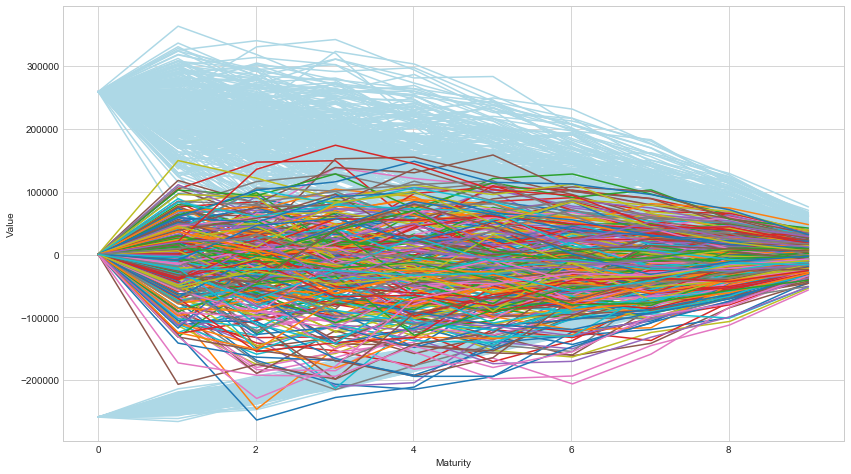

In [111]:
fig = plt.figure(figsize=(14,8))
plt.plot(time_grid, -fix.T, color = "lightblue")
plt.plot(time_grid, flt.T, color = "lightblue")
plt.plot(time_grid, swapExposure.T)
plt.xlabel("Maturity")
plt.ylabel("Value")
plt.show()

In [103]:
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)
swap.setPricingEngine(engine)
npv,_,_ = swapPathNPV(swap, date_grid[0], today, date_grid)(0)
print("Swap NPV a t0: %.4f" % npv)
print("Quantlib NPV a t0: %.4f" % swap.NPV())
print("Errore : %.8f" % (npv - swap.NPV()))

Swap NPV a t0: 325.7915
Quantlib NPV a t0: 325.7915
Errore : -0.00000000


#### EXPOSURE AND XVA

In [51]:
# passare la curva di PD adatta per il rating
pd_dates =  [today + ql.Period(i, ql.Years) for i in range(11)]
pdcurve = [0.02 * i for i in range(11)] # pd curve 
pd_curve = ql.HazardRateCurve(pd_dates,pdcurve,ql.Actual365Fixed())

In [58]:
pd_curve.enableExtrapolation()
# discounting dei valori futuri simulati del portafoglio:
# (vengono usate le curve di zcb calcolate a data futura per ogni short rate)
discounted_exposure = np.zeros(swapExposure.shape)
discount_factors = np.zeros(len(time_grid))

In [63]:
for i in range(swapExposure.shape[1]):
    discount_factors[i] = t0_curve.discount(i)
    discounted_exposure[:,i] = swapExposure[:,i]*discount_factors[i]

In [67]:
swapExposure[swapExposure<0] = 0
discounted_exposure[discounted_exposure<0] = 0

In [85]:
exp_exposure = np.sum(swapExposure, axis = 0)/nPath
exp_disc_exposure = np.sum(discounted_exposure, axis = 0)/nPath

In [87]:
defaultProb_vec = np.vectorize(pd_curve.defaultProbability) # 
dPD = defaultProb_vec(time_grid[:-1], time_grid[1:]) 
recovery = 0.4
CVA = (1-recovery) * np.sum(exp_disc_exposure[1:] * dPD)  # CVA del portafoglio

In [88]:
exp_disc_exposure[1:] * dPD

array([ 347.49925522,  718.50803867, 1135.9854498 , 1245.95225766,
       1320.41471232, 1254.57223301,  938.8469207 ,  602.02965554,
        273.69771082])

In [89]:
dPD

array([0.02033827, 0.03846466, 0.05495675, 0.06827187, 0.07796165,
       0.08450628, 0.08554206, 0.08413882, 0.08009567])

In [90]:
pd_curve.defaultProbability(time_grid[0], time_grid[0])

0.0